In [16]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file
from skimage.segmentation import find_boundaries

from stardist import edt_prob, star_dist, dist_to_coord, polygons_to_label, fill_label_holes
from stardist import random_label_cmap, draw_polygons, ray_angles
from stardist import non_maximum_suppression
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches
np.random.seed(42)
lbl_cmap = random_label_cmap()

# Read the input images and create a list of training images

In [22]:
X = sorted(glob('/data/u934/service_imagerie/v_kapoor/from_Ozge_for_curvature/multiple_cells/images/*.tif'))
Y = sorted(glob('/data/u934/service_imagerie/v_kapoor/from_Ozge_for_curvature/multiple_cells/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [23]:
X = list(map(imread,X))
Y = list(map(imread,Y))


Fill holes in the labelled image and display an example training image with the Raw input and Ground Truth labels

In [25]:
i = 0
img, lbl = X[i], fill_label_holes(Y[i].astype(int))

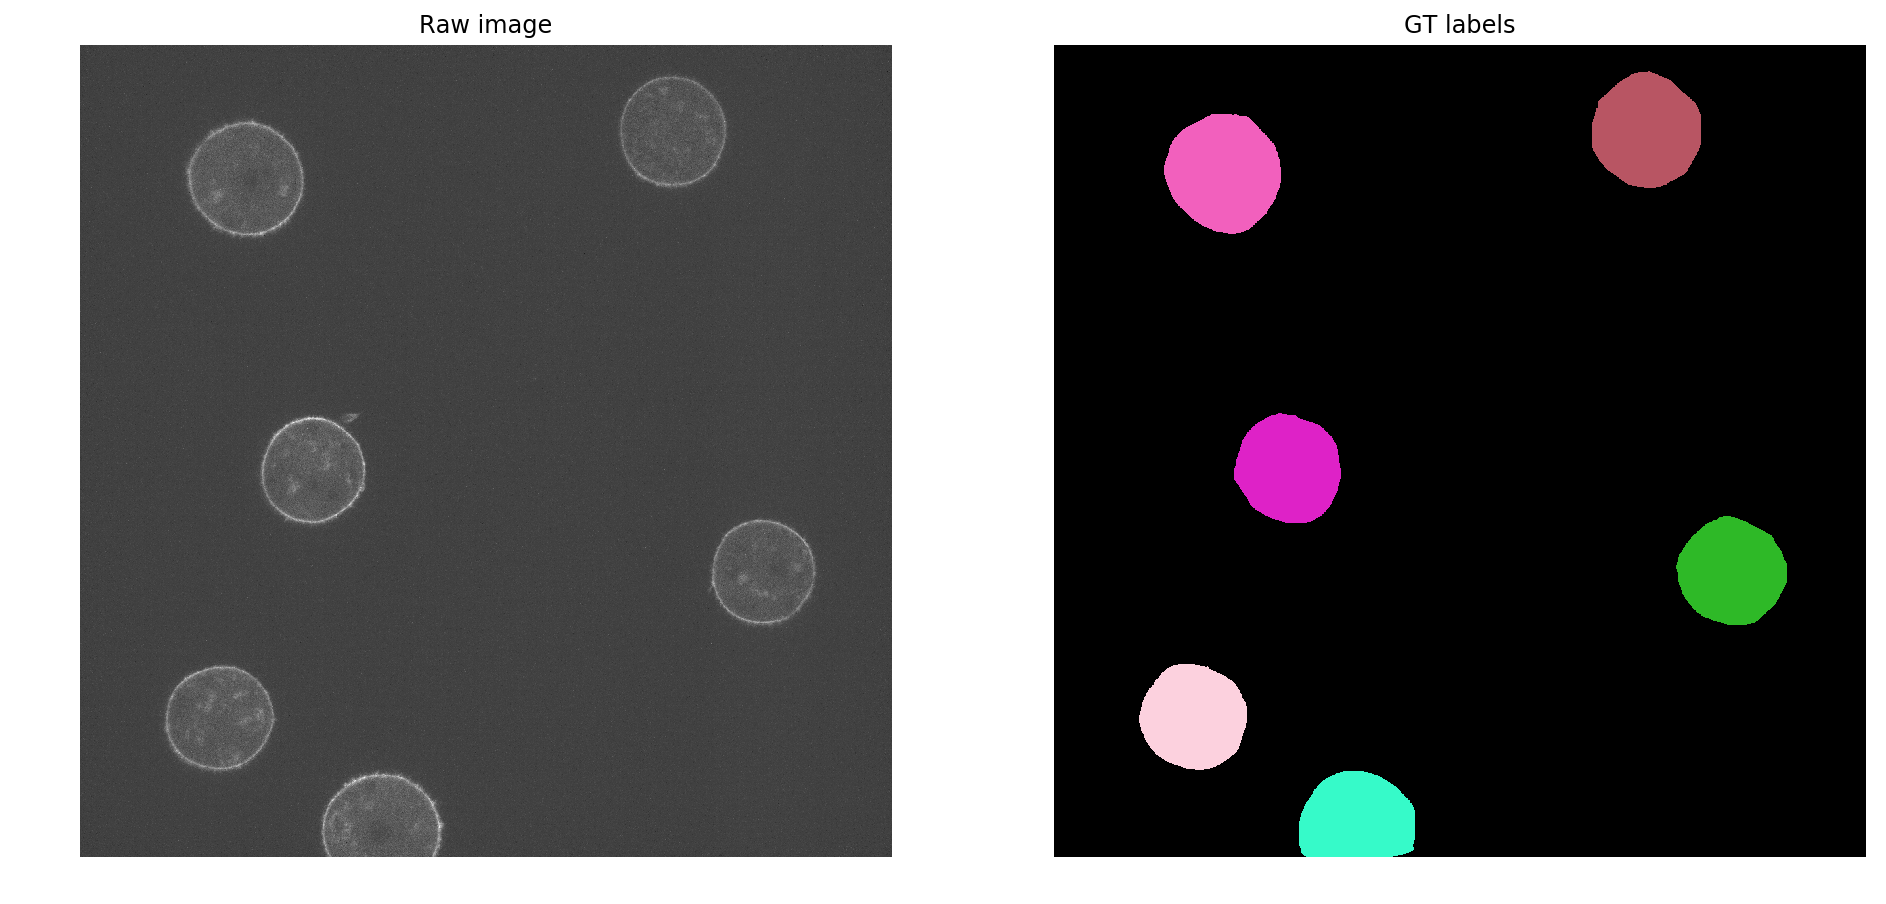

In [26]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

Specify the number of rays to be used in the stardist model and display it for certain angle values

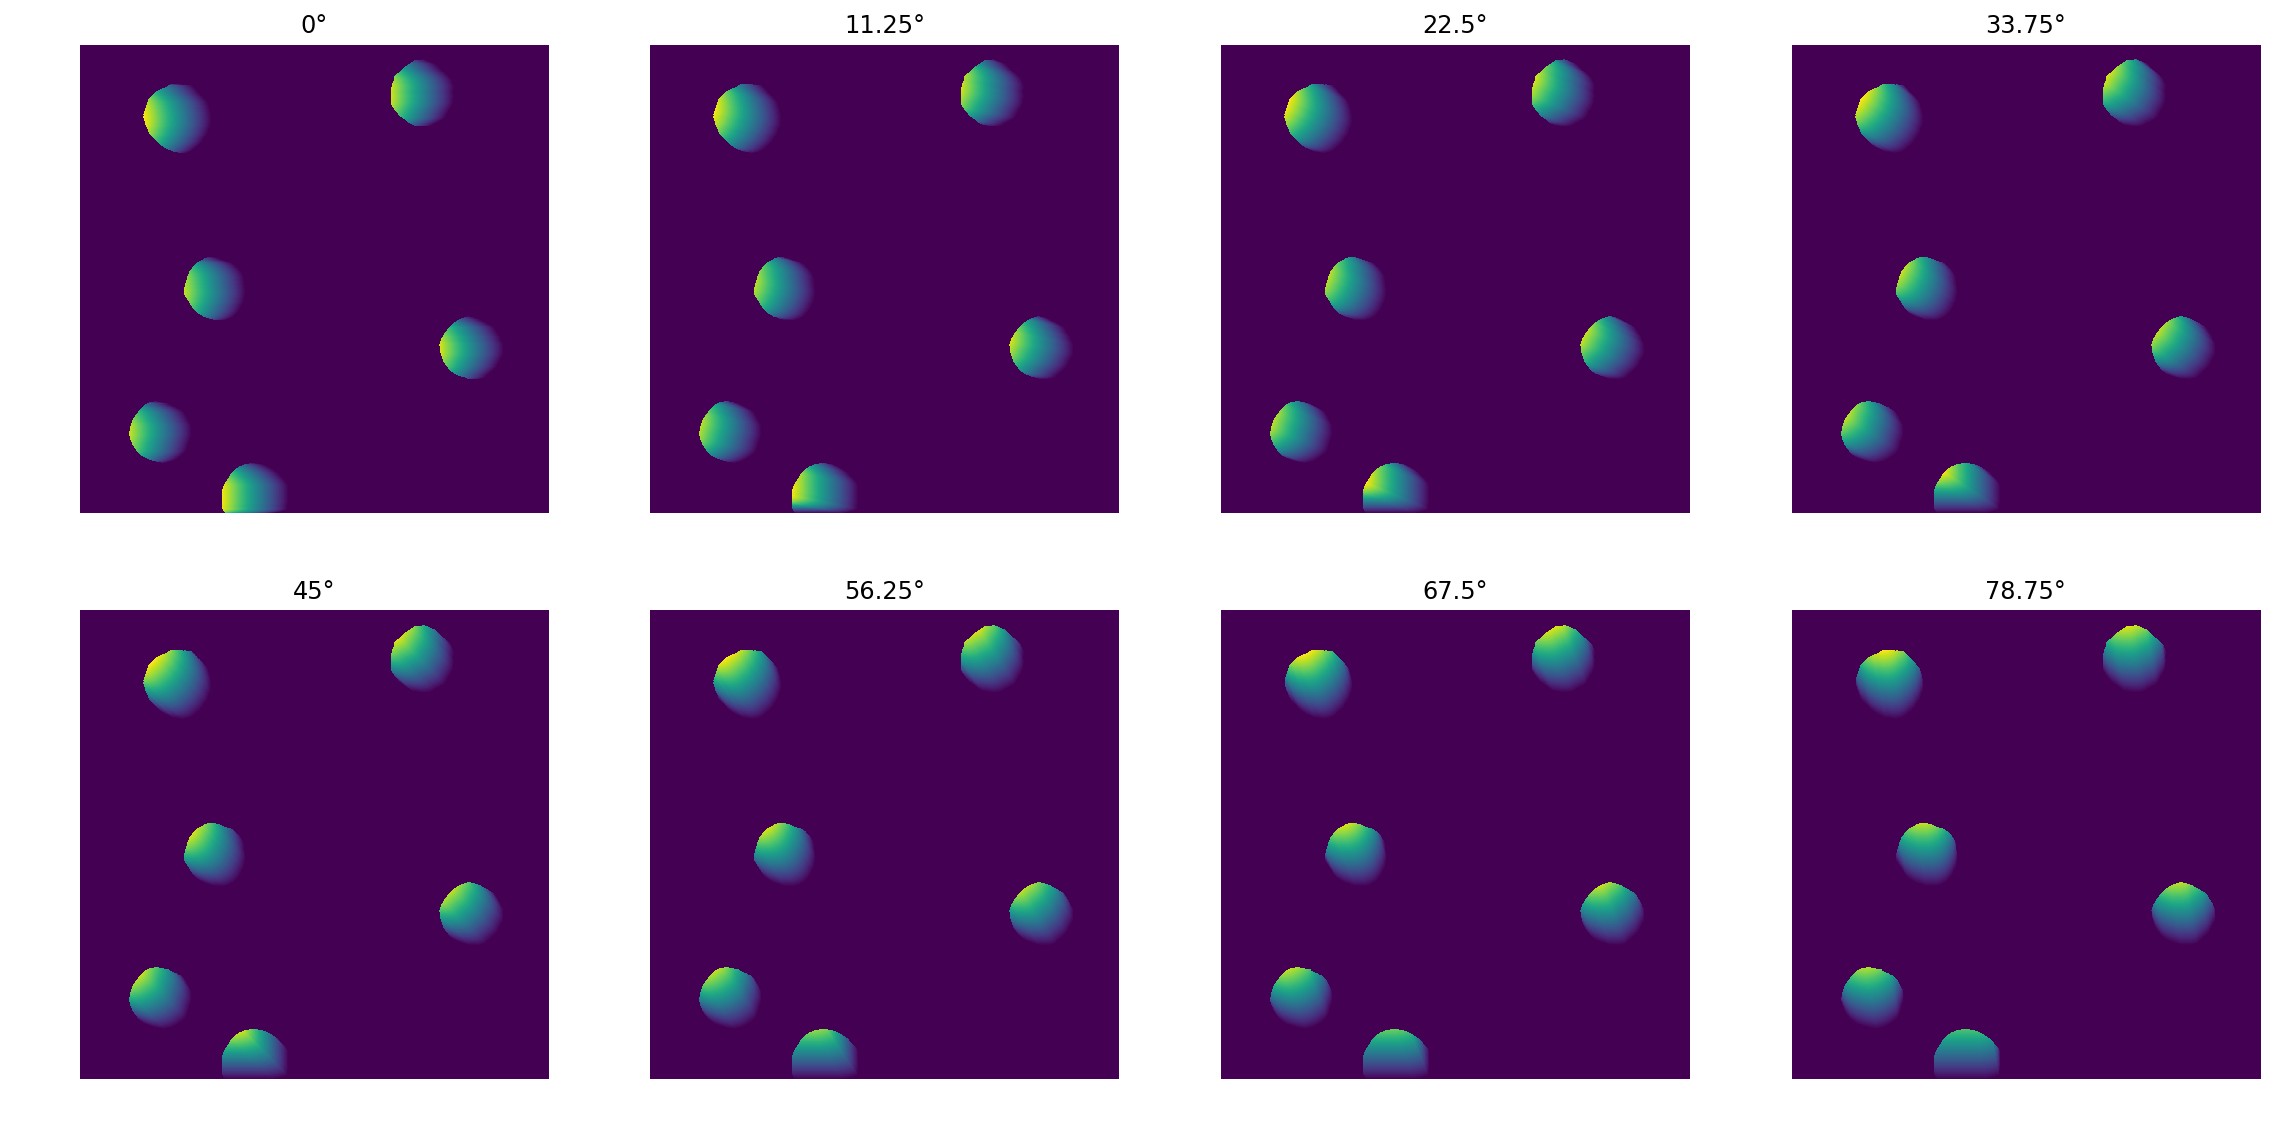

In [27]:
n_rays = 32
angl = ray_angles(n_rays)
dist = star_dist(lbl,n_rays)
fig, ax = plt.subplots(2,4, figsize=(16,8))
for a,d,g in zip(ax.flat,np.moveaxis(dist,-1,0),angl):
    a.imshow(d,cmap='viridis')
    a.set_title('%g°'%np.rad2deg(g))
    a.axis('off')
plt.tight_layout()
None;

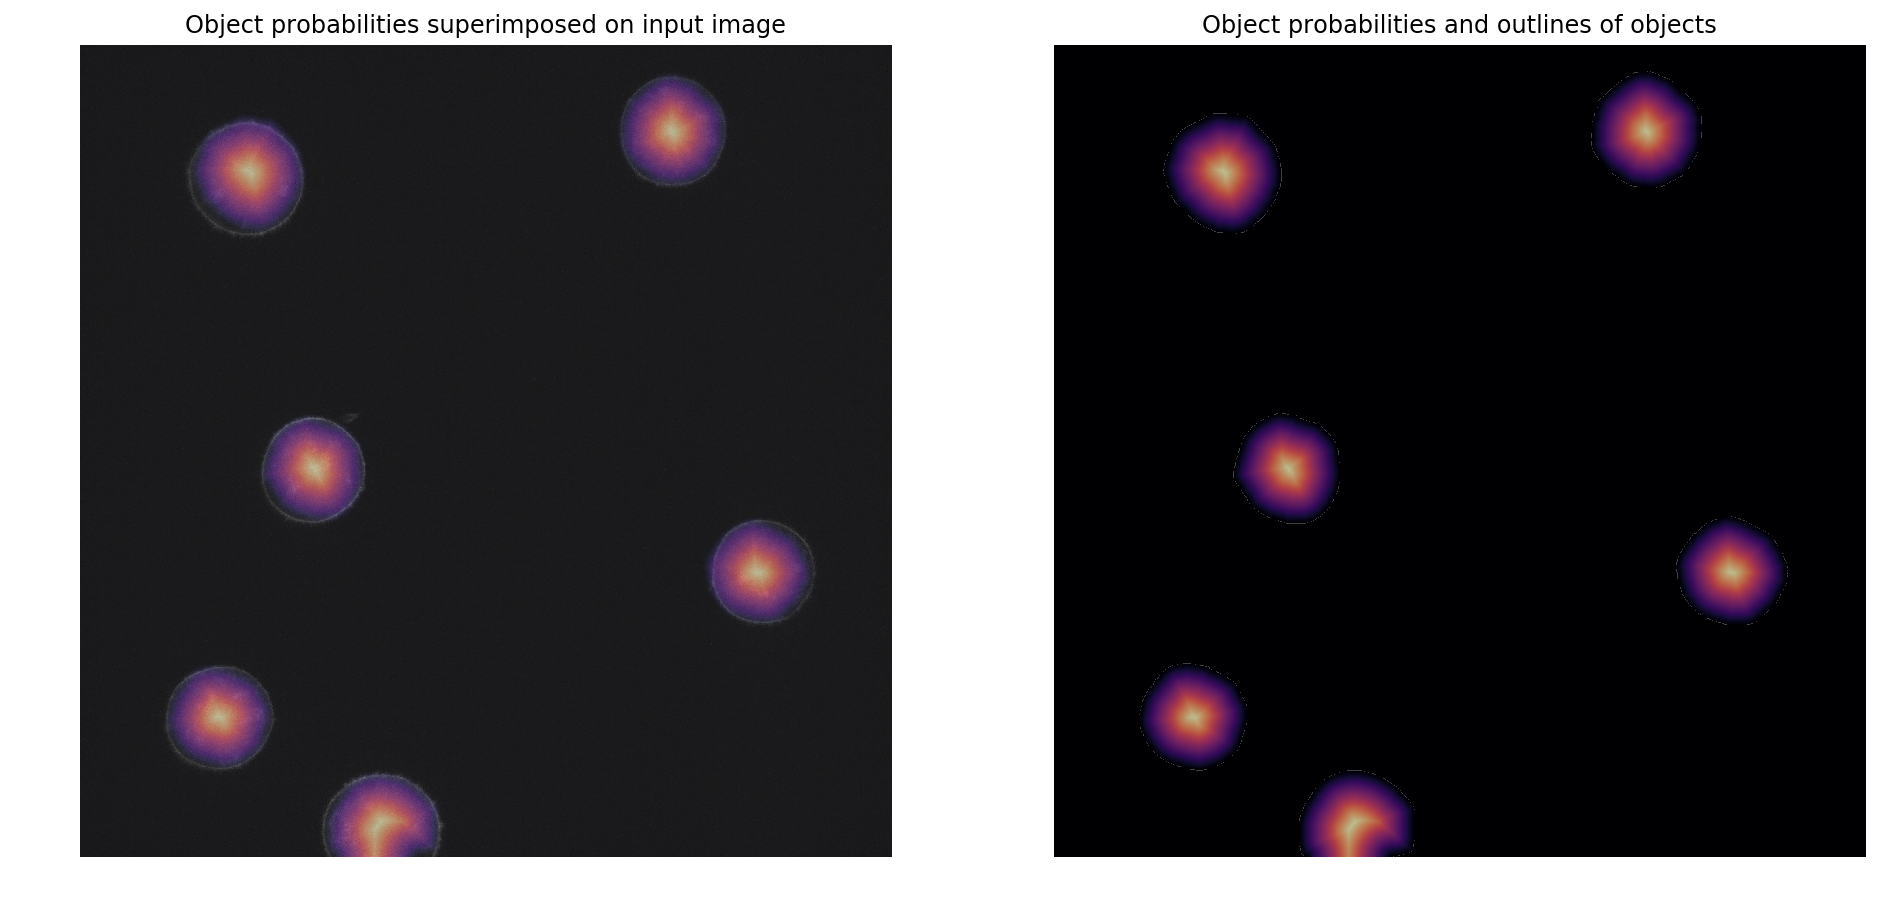

In [28]:
prob = edt_prob(lbl)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.imshow(prob,cmap='magma',alpha=0.6)
plt.title('Object probabilities superimposed on input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(find_boundaries(lbl!=0,mode='outer'),cmap='gray')
plt.imshow(prob,cmap='magma',alpha=0.75)
plt.title('Object probabilities and outlines of objects')
plt.axis('off')
None;

In [29]:

prob = edt_prob(lbl)
dist = star_dist(lbl, n_rays)

In [30]:
coord = dist_to_coord(dist)

In [31]:
points = non_maximum_suppression(coord, prob, prob_thresh=0.5)

In [32]:
labels = polygons_to_label(coord, prob, points)

Display the results of a star convex polygon fit on the training data

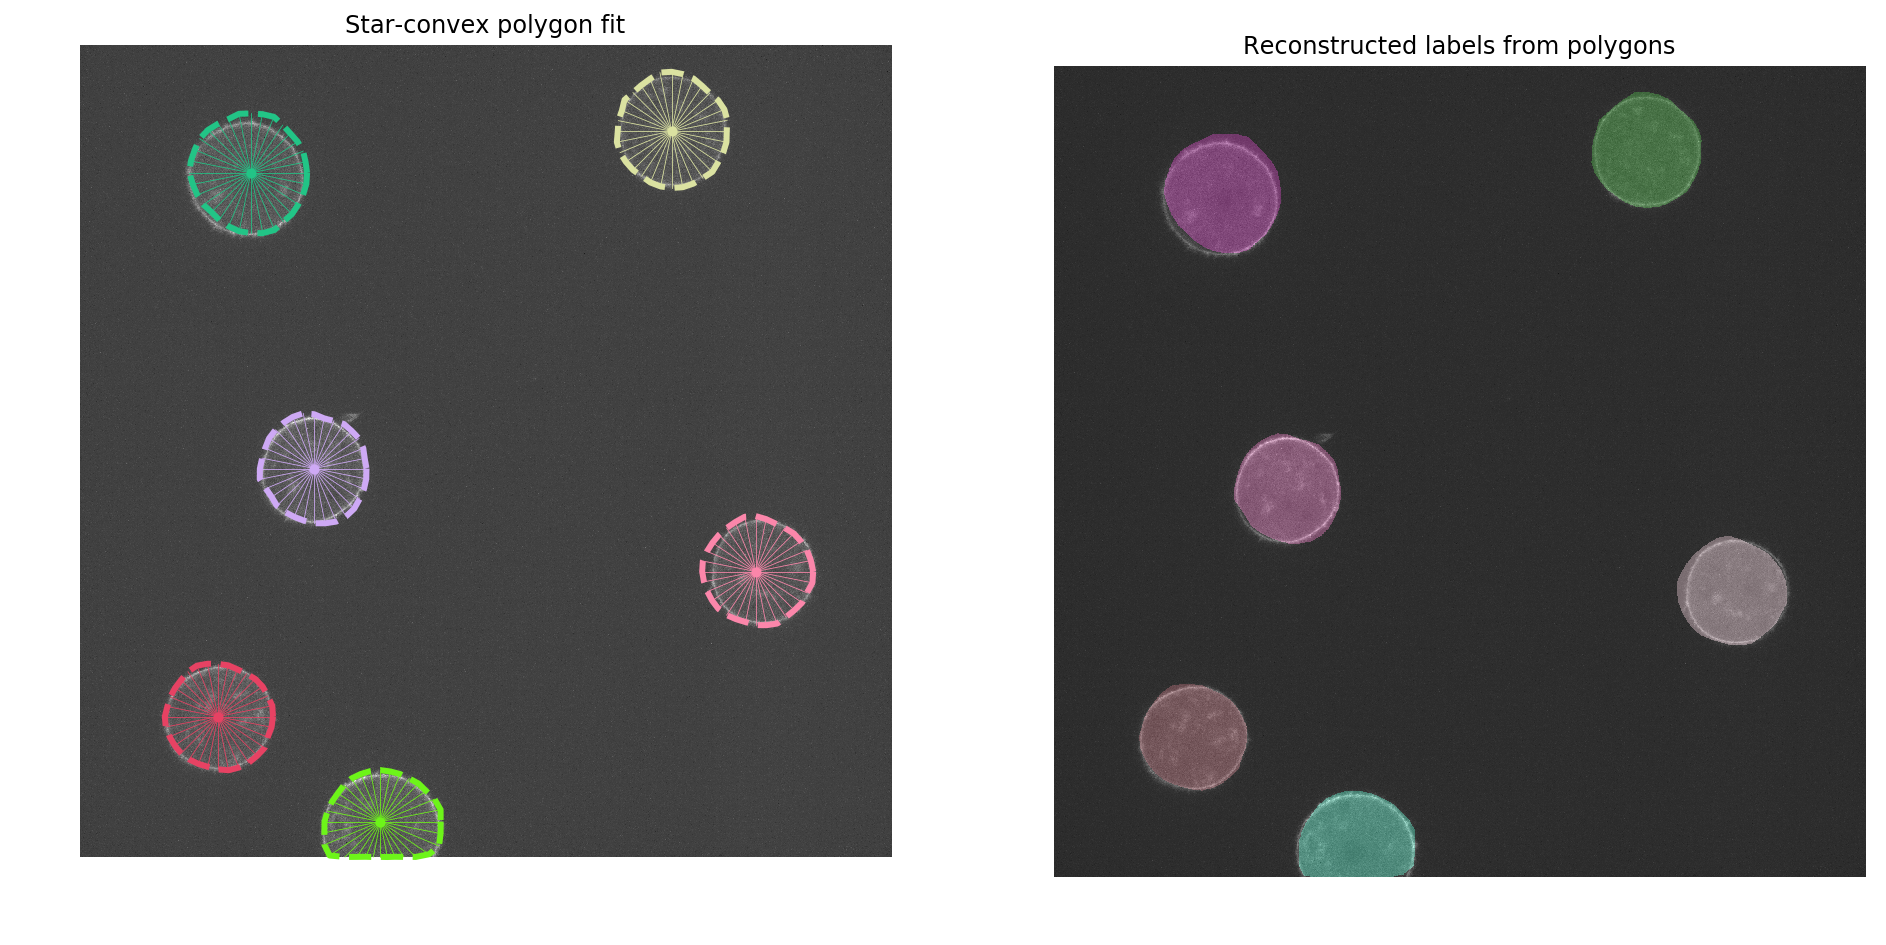

In [33]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
draw_polygons(coord,prob,points,show_dist=True)
plt.axis('off')
plt.title('Star-convex polygon fit')
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.imshow(labels,cmap=lbl_cmap,alpha=0.3)
plt.axis('off')
plt.title('Reconstructed labels from polygons')
None;

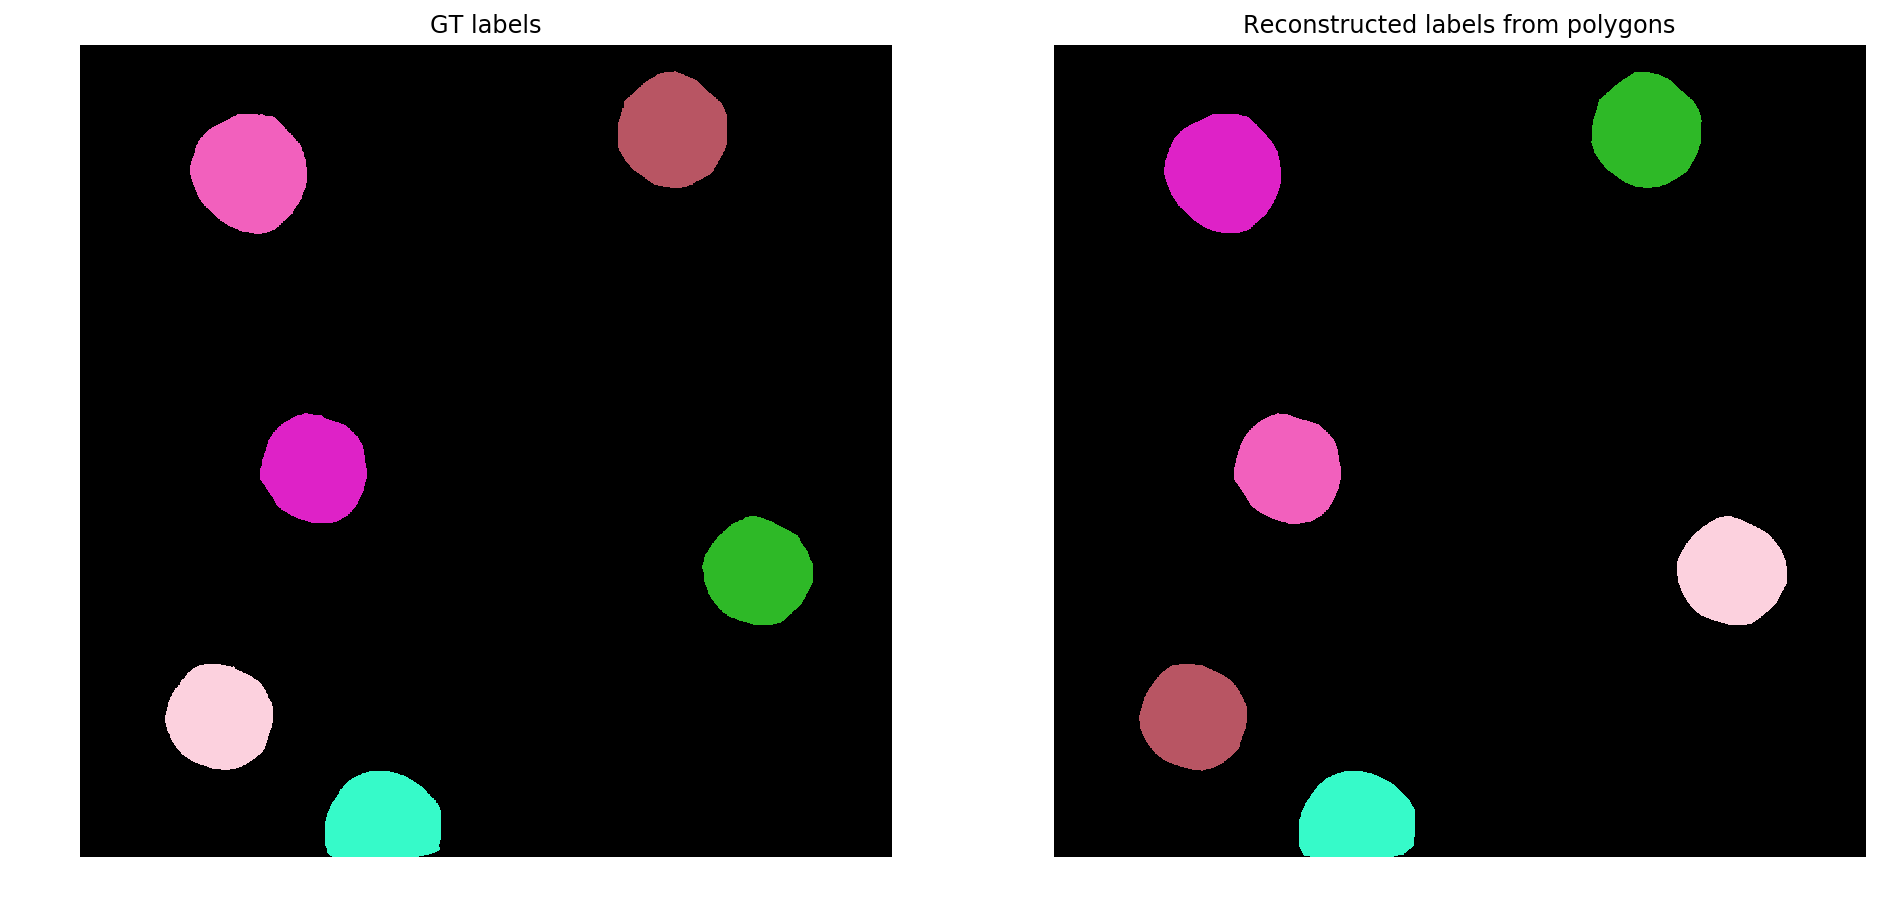

In [34]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(lbl,   cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
plt.subplot(122); plt.imshow(labels,cmap=lbl_cmap); plt.axis('off'); plt.title('Reconstructed labels from polygons')
None;